## **1. Mount Drive + import library + konfigurasi dasar**

In [ ]:
# CELL 1 — mount drive & imports
from google.colab import drive
drive.mount('/content/drive')

# imports
import os, random, itertools
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from IPython.display import display, Markdown

print("TensorFlow:", tf.__version__)


Mounted at /content/drive
TensorFlow: 2.19.0


## **2.Paths & quick checks**

In [ ]:
# CELL 2 — path dataset
DATA_ROOT = '/content/drive/MyDrive/dataset_gayasenilukisan'   # <- sesuaikan jika beda
train_dir = os.path.join(DATA_ROOT, 'subset_train')
test_dir  = os.path.join(DATA_ROOT, 'subset_test')

print("Train exists:", os.path.exists(train_dir), "  Test exists:", os.path.exists(test_dir))
print("Train folders:", sorted(os.listdir(train_dir)) if os.path.exists(train_dir) else "NO")
print("Test folders:", sorted(os.listdir(test_dir)) if os.path.exists(test_dir) else "NO")

# Quick count per class in train
if os.path.exists(train_dir):
    for cls in sorted(os.listdir(train_dir)):
        p = os.path.join(train_dir, cls)
        if os.path.isdir(p):
            print(f"{cls}: {len([f for f in os.listdir(p) if f.lower().endswith(('.jpg','.jpeg','.png'))])} images")


Train exists: True   Test exists: True
Train folders: ['Abstract Expressionism', 'Cubism', 'Early Renaissance', 'Ukiyo-e']
Test folders: ['Abstract Expressionism', 'Cubism', 'Early Renaissance', 'Ukiyo-e']
Abstract Expressionism: 1548 images
Cubism: 1246 images
Early Renaissance: 935 images
Ukiyo-e: 854 images


## **3. Parameters + generators (augmentasi untuk train; test tanpa augment)**

In [ ]:
# CELL 3 — parameters & data generators
IMG_SIZE = 224          # pakai 224 untuk MobileNetV2; nyaman dan powerful
BATCH_SIZE = 16         # aman untuk Colab gratis (turunkan ke 8 jika OOM)
EPOCHS = 30
SEED = 42

# augmentation (train) — cukup agresif untuk menambah variasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2   # 20% dari subset_train dipakai validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

# flow_from_directory: ambil train dan validation dari subset_train
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=SEED
)

# test generator (dari subset_test) — shuffle=False agar mapping filenames->labels terjaga
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# class mapping
class_indices = train_gen.class_indices
classes = list(class_indices.keys())
NUM_CLASSES = len(classes)
print("Classes:", classes, "Num classes:", NUM_CLASSES)


Found 3668 images belonging to 4 classes.
Found 915 images belonging to 4 classes.
Found 1548 images belonging to 4 classes.
Classes: ['Abstract Expressionism', 'Cubism', 'Early Renaissance', 'Ukiyo-e'] Num classes: 4


## **4. Menampilkan contoh gambar per kelas (visualisasi dataset sampel)**

**Abstract Expressionism** : 1548 images

**Cubism** : 1246 images

**Early Renaissance** : 935 images

**Ukiyo-e** : 854 images

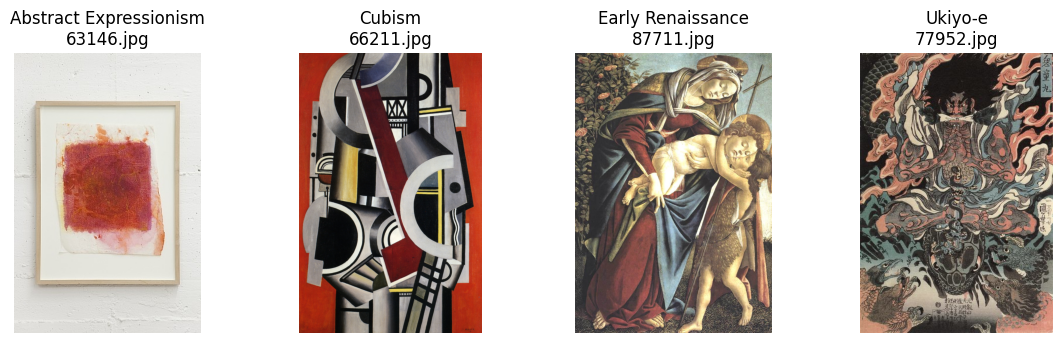

In [ ]:
# CELL 4 — show sample images per class
import math
plt.figure(figsize=(14,8))
cols = 4
for i, cls in enumerate(classes):
    cls_path = os.path.join(train_dir, cls)
    imgs = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    if len(imgs)==0: continue
    imgfile = os.path.join(cls_path, random.choice(imgs))
    img = plt.imread(imgfile)
    ax = plt.subplot(2, cols, i+1)
    ax.imshow(img)
    ax.set_title(f"{cls}\n{os.path.basename(imgfile)}")
    ax.axis('off')

# show counts
for cls in classes:
    n = len([f for f in os.listdir(os.path.join(train_dir, cls)) if f.lower().endswith(('.jpg','.jpeg','.png'))])
    display(Markdown(f"**{cls}** : {n} images"))


## **5. Build model (Transfer Learning MobileNetV2 + head)**

In [ ]:
# CELL 5 — build transfer-learning model (MobileNetV2 base)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False   # awalnya freeze

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs, name='mobilenetv2_finetune_head')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_finetune_head"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,624,452 (10.01 MB)

 Trainable params: 363,908 (1.39 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

## **6. Callbacks: early stopping, checkpoint, reduce LR**

In [ ]:
# CELL 6 — callbacks
checkpoint_path = '/content/drive/MyDrive/model_gayasenilukisan_best.keras'
checkpoint_cb = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', verbose=1)
earlystop_cb = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
reduce_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-7, verbose=1)
callbacks = [checkpoint_cb, earlystop_cb, reduce_cb]


## **7. Train (head only)**

In [ ]:
# CELL 7 — training head
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4153 - loss: 1.4244
Epoch 1: val_loss improved from inf to 0.67563, saving model to /content/drive/MyDrive/model_gayasenilukisan_best.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 883s 4s/step - accuracy: 0.4156 - loss: 1.4234 - val_accuracy: 0.7541 - val_loss: 0.6756 - learning_rate: 1.0000e-04
Epoch 2/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6787 - loss: 0.8540
Epoch 2: val_loss improved from 0.67563 to 0.52680, saving model to /content/drive/MyDrive/model_gayasenilukisan_best.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - accuracy: 0.6788 - loss: 0.8537 - val_accuracy: 0.8011 - val_loss: 0.5268 - learning_rate: 1.0000e-04
Epoch 3/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7365 - loss: 0.6716
Epoch 3: val_loss improved from 0.52680 to 0.46657, saving model to /content/drive/MyDrive/model_gayasenilukisan_best.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.7365 - loss: 0.6716 - val_acc

## **8. Unfreeze some base layers and fine-tune (recommended for higher accuracy)**

In [ ]:
# CELL 8 — fine-tune some top layers of base model
base_model.trainable = True

# freeze lower layers, fine-tune last N layers
fine_tune_at = 100   # angka bisa disesuaikan
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)
# append histories
for k in fine_history.history:
    history.history.setdefault(k, []).extend(fine_history.history[k])


Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7857 - loss: 0.6050
Epoch 1: val_loss did not improve from 0.31049
230/230 ━━━━━━━━━━━━━━━━━━━━ 416s 2s/step - accuracy: 0.7857 - loss: 0.6048 - val_accuracy: 0.8525 - val_loss: 0.3636 - learning_rate: 1.0000e-05
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7940 - loss: 0.5352
Epoch 2: val_loss did not improve from 0.31049
230/230 ━━━━━━━━━━━━━━━━━━━━ 393s 2s/step - accuracy: 0.7941 - loss: 0.5351 - val_accuracy: 0.8689 - val_loss: 0.3578 - learning_rate: 1.0000e-05
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8297 - loss: 0.4266
Epoch 3: val_loss did not improve from 0.31049
230/230 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.8297 - loss: 0.4266 - val_accuracy: 0.8667 - val_loss: 0.3569 - learning_rate: 1.0000e-05
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8427 - loss: 0.4320
Epoch 4: val_loss did not improve from 0.31049
230/230 ━━━━━━━━━━━━━━━━━━━━ 417s 

## **9. Save final model & print summary**

In [ ]:
# CELL 9 — save final model (keras native recommended)
final_model_path = '/content/drive/MyDrive/model_gayasenilukisan_final.keras'
model.save(final_model_path)
print("Saved final model to:", final_model_path)
model.summary()


Saved final model to: /content/drive/MyDrive/model_gayasenilukisan_final.keras


Model: "mobilenetv2_finetune_head"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,075,150 (26.99 MB)

 Trainable params: 2,225,348 (8.49 MB)

 Non-trainable params: 399,104 (1.52 MB)

 Optimizer params: 4,450,698 (16.98 MB)

## **10. Plots: training curves (accuracy & loss)**

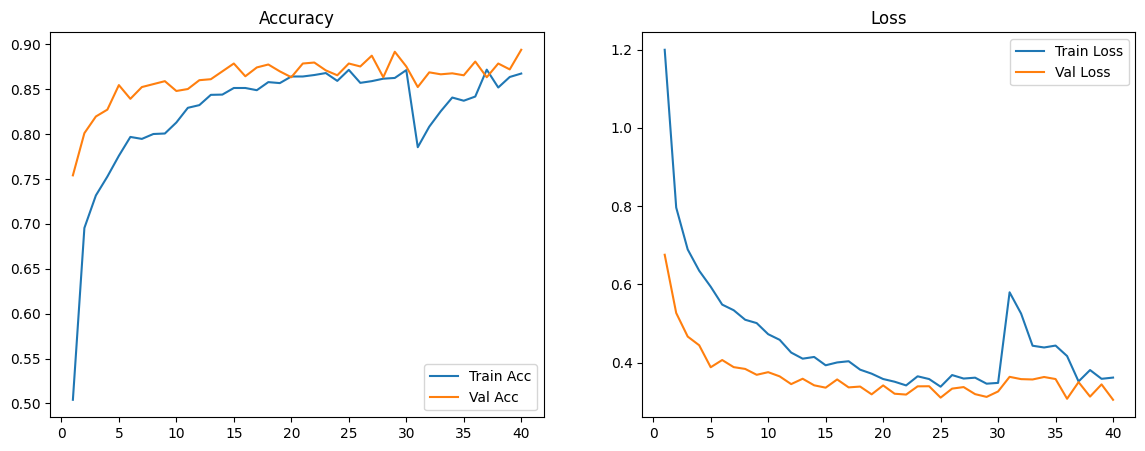

In [ ]:
# CELL 10 — plot training curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc)+1)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Train Acc')
plt.plot(epochs_range, val_acc, label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()


## **11. Evaluate on test set: predictions, confusion matrix, classification report, AUC**

Loaded best model from checkpoint.
Skipping image 531 due to error: image file is truncated (52 bytes not processed)
Skipped 1 images during evaluation.


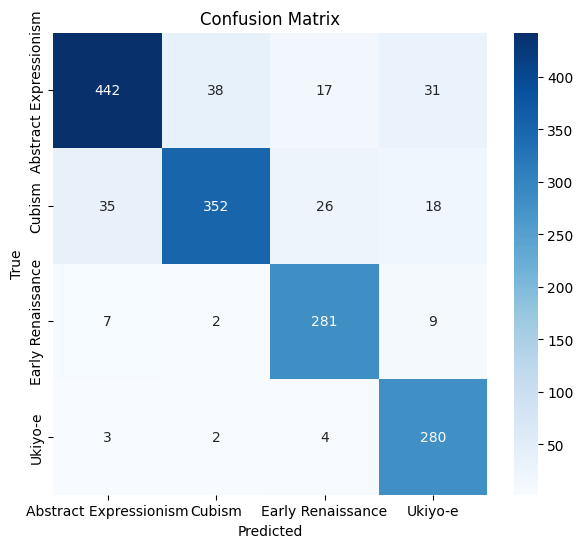

Classification Report:

                        precision    recall  f1-score   support

Abstract Expressionism     0.9076    0.8371    0.8709       528
                Cubism     0.8934    0.8167    0.8533       431
     Early Renaissance     0.8567    0.9398    0.8963       299
               Ukiyo-e     0.8284    0.9689    0.8931       289

              accuracy                         0.8759      1547
             macro avg     0.8715    0.8906    0.8784      1547
          weighted avg     0.8790    0.8759    0.8751      1547

Test accuracy: 87.59%


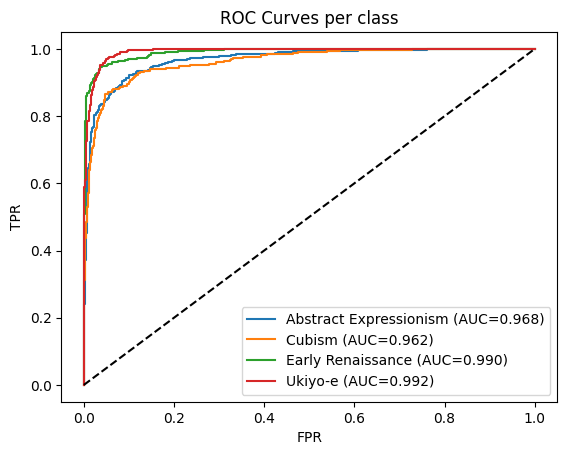

AUC per class: {'Abstract Expressionism': np.float64(0.9681), 'Cubism': np.float64(0.9622), 'Early Renaissance': np.float64(0.9901), 'Ukiyo-e': np.float64(0.9921)}
Macro AUC: 0.9781117738385812


In [17]:
# CELL 11 — evaluate on test set
# Load best weights if checkpoint saved
if os.path.exists(checkpoint_path):
    model = tf.keras.models.load_model(checkpoint_path)
    print("Loaded best model from checkpoint.")

# Predict on test set (test_gen has batch_size=1 and shuffle=False)
test_steps = len(test_gen)
y_true = []
y_pred = []
y_prob = []

# Add a counter for skipped images
skipped_images = 0

for i in range(test_steps):
    try:
        x, y = test_gen[i]  # batch_size=1
        prob = model.predict(x, verbose=0) # Suppress verbose output for each prediction
        pred = np.argmax(prob, axis=1)[0]
        true = np.argmax(y, axis=1)[0]
        y_true.append(true)
        y_pred.append(pred)
        y_prob.append(prob[0])
    except Exception as e:
        # Handle truncated image error or other potential issues during loading/prediction
        print(f"Skipping image {i} due to error: {e}")
        skipped_images += 1
        continue # Skip to the next image

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

print(f"Skipped {skipped_images} images during evaluation.")

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

# classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

# overall accuracy
acc = np.mean(y_true==y_pred)
print(f"Test accuracy: {acc*100:.2f}%")

# Macro AUC (one-vs-rest)
try:
    y_true_bin = to_categorical(y_true, num_classes=NUM_CLASSES)
    aucs = []
    for i in range(NUM_CLASSES):
        fpr, tpr, _ = roc_curve(y_true_bin[:,i], y_prob[:,i])
        auc_score = auc(fpr, tpr)
        aucs.append(auc_score)
        plt.plot(fpr, tpr, label=f"{classes[i]} (AUC={auc_score:.3f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curves per class')
    plt.legend(); plt.show()
    print("AUC per class:", dict(zip(classes, [round(a,4) for a in aucs])))
    print("Macro AUC:", np.mean(aucs))
except Exception as e:
    print("Could not compute AUC:", e)

## **12. Uji Coba Prediksi Gaya Seni Lukisan**

📤 Silakan upload gambar lukisan yang ingin diklasifikasikan:


Saving 1199.jpg to 1199.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


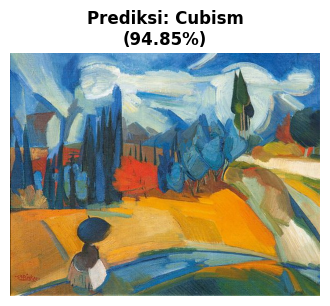

Gambar '1199.jpg' diprediksi sebagai: Cubism (94.85%)

✅ Proses prediksi selesai. Kamu bisa upload gambar lain lagi dengan menjalankan cell ini ulang.


In [29]:
#Uji Coba

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import os

# -----------------------------------------------
# 🔹 1. Load model hasil training
# -----------------------------------------------
model_path = "/content/drive/MyDrive/model_gayasenilukisan_best.keras"
model = load_model(model_path)

# -----------------------------------------------
# 🔹 2. Label kelas sesuai urutan folder dataset_train kamu
# -----------------------------------------------
class_labels = ['Abstract Expressionism', 'Cubism', 'Early Renaissance', 'Ukiyo-e']

# -----------------------------------------------
# 🔹 3. Upload gambar dari perangkat lokal
# -----------------------------------------------
print("📤 Silakan upload gambar lukisan yang ingin diklasifikasikan:")
uploaded = files.upload()

# -----------------------------------------------
# 🔹 4. Proses dan prediksi setiap gambar yang diupload
# -----------------------------------------------
for fn in uploaded.keys():
    img_path = fn

    # Ganti ukuran ke (224, 224) agar sesuai model training
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Prediksi
    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction)
    predicted_label = class_labels[predicted_index]
    confidence = np.max(prediction) * 100

    # Tampilkan hasil
    plt.figure(figsize=(4,4))
    plt.imshow(image.load_img(img_path))
    plt.axis('off')
    plt.title(f"Prediksi: {predicted_label}\n({confidence:.2f}%)", fontsize=12, weight='bold')
    plt.show()

    print(f"Gambar '{fn}' diprediksi sebagai: {predicted_label} ({confidence:.2f}%)\n")

print("✅ Proses prediksi selesai. Kamu bisa upload gambar lain lagi dengan menjalankan cell ini ulang.")
